In [1]:
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [2]:
path = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution\\GIFs\\9.805413927057321"#10.727024154887758"


#path = "C:\\Users\\niels\Downloads\\GRN_runs\GIFs\\3.7972348391243984"

# Spider: 6.900156503920964", Snake: 9.93067072271658, Different: 6.9331836719167415
# Load the data
locations = np.loadtxt(f"{path}\\locations.csv",
                  delimiter = ',')

concentrations = {}
for tf in range(1, 6):
    # concentrations[tf] = np.loadtxt(f"{path}\\concentrations_GRN_TF{tf}.csv",
    #               delimiter = ',')
    concentrations[tf] = np.loadtxt(f"{path}\\concentrations_TF{tf}.csv",
                  delimiter = ',')


#[cell.developed_module.substrate_coordinates[0], cell.developed_module.substrate_coordinates[1], 
#        slot4coordinates, potential_module_coord[0], potential_module_coord[1]]

# FRONT = 0
# RIGHT = 1
# BACK = 2
# LEFT = 3

In [3]:
coordinates, directions = [], {}
# Append core coordinates --> 3 x 3 central grid
for coord in [(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0)]:
    coordinates.append([coord[0], coord[1]])

xbounds = [0, 0]
ybounds = [0, 0]
for loc in locations:
    coordinates.append([loc[3], loc[4]])
    directions[tuple(coordinates[-1])] = {0: (int(np.sign(loc[3] - loc[0])), int(np.sign(loc[4] - loc[1])))}
    directions[tuple(coordinates[-1])][2] = (-int(np.sign(loc[3] - loc[0])), -int(np.sign(loc[4] - loc[1])))
    
    if (directions[tuple(coordinates[-1])][0] == (1, 0)):
        directions[tuple(coordinates[-1])][1] = (0, 1)
        directions[tuple(coordinates[-1])][3] = (0, -1)
    elif (directions[tuple(coordinates[-1])][0] == (0, 1)):
        directions[tuple(coordinates[-1])][1] = (-1, 0)
        directions[tuple(coordinates[-1])][3] = (1, 0)
    elif (directions[tuple(coordinates[-1])][0] == (-1, 0)):
        directions[tuple(coordinates[-1])][1] =  (0, -1)
        directions[tuple(coordinates[-1])][3] = (0, 1)
    elif (directions[tuple(coordinates[-1])][0] == (0, -1)):
        directions[tuple(coordinates[-1])][1] = (1, 0)
        directions[tuple(coordinates[-1])][3] = (-1, 0)
    else:
        print("Error")

    
    # x-coordinate
    try:
        assert directions[tuple(coordinates[-1])][0][0] + loc[0] == loc[3]
    except:
        assert directions[tuple(coordinates[-1])][0][0] * 2 + loc[0] == loc[3]
    # y-coordinate
    try:
        assert directions[tuple(coordinates[-1])][0][1] + loc[1] == loc[4]
    except:
        assert directions[tuple(coordinates[-1])][0][1] * 2 + loc[1] == loc[4]

    
    # Store bounds
    if loc[3] < xbounds[0]:
        xbounds[0] = loc[3]
    if loc[3] > xbounds[1]:
        xbounds[1] = loc[3]
    if loc[4] < ybounds[0]:
        ybounds[0] = loc[4]
    if loc[4] > ybounds[1]:
        ybounds[1] = loc[4]

# Append slot coordinates
xbounds = [min([xbounds[0], - 1]), max([xbounds[1], 1])]
ybounds = [min([ybounds[0], - 1]), max([ybounds[1], 1])]

In [4]:
grid = np.ones((max([int(xbounds[1] - xbounds[0]) + 1, 3]), max([int(ybounds[1] - ybounds[0] + 1), 3])))

# Set to 0 if not in body
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if [i + xbounds[0], j + ybounds[0]] not in coordinates:
            grid[i, j] = 0


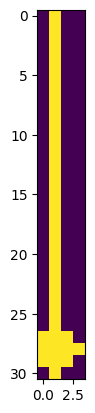

In [5]:
import matplotlib.pyplot as plt
plt.imshow(grid)

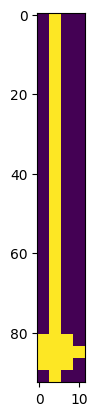

In [6]:
# Expand each grid cell to 3 x 3
expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        expanded_grid[i * 3: (i + 1) * 3, j * 3: (j + 1) * 3] = grid[i, j]

plt.imshow(expanded_grid)

# Image of Concentrations over Time

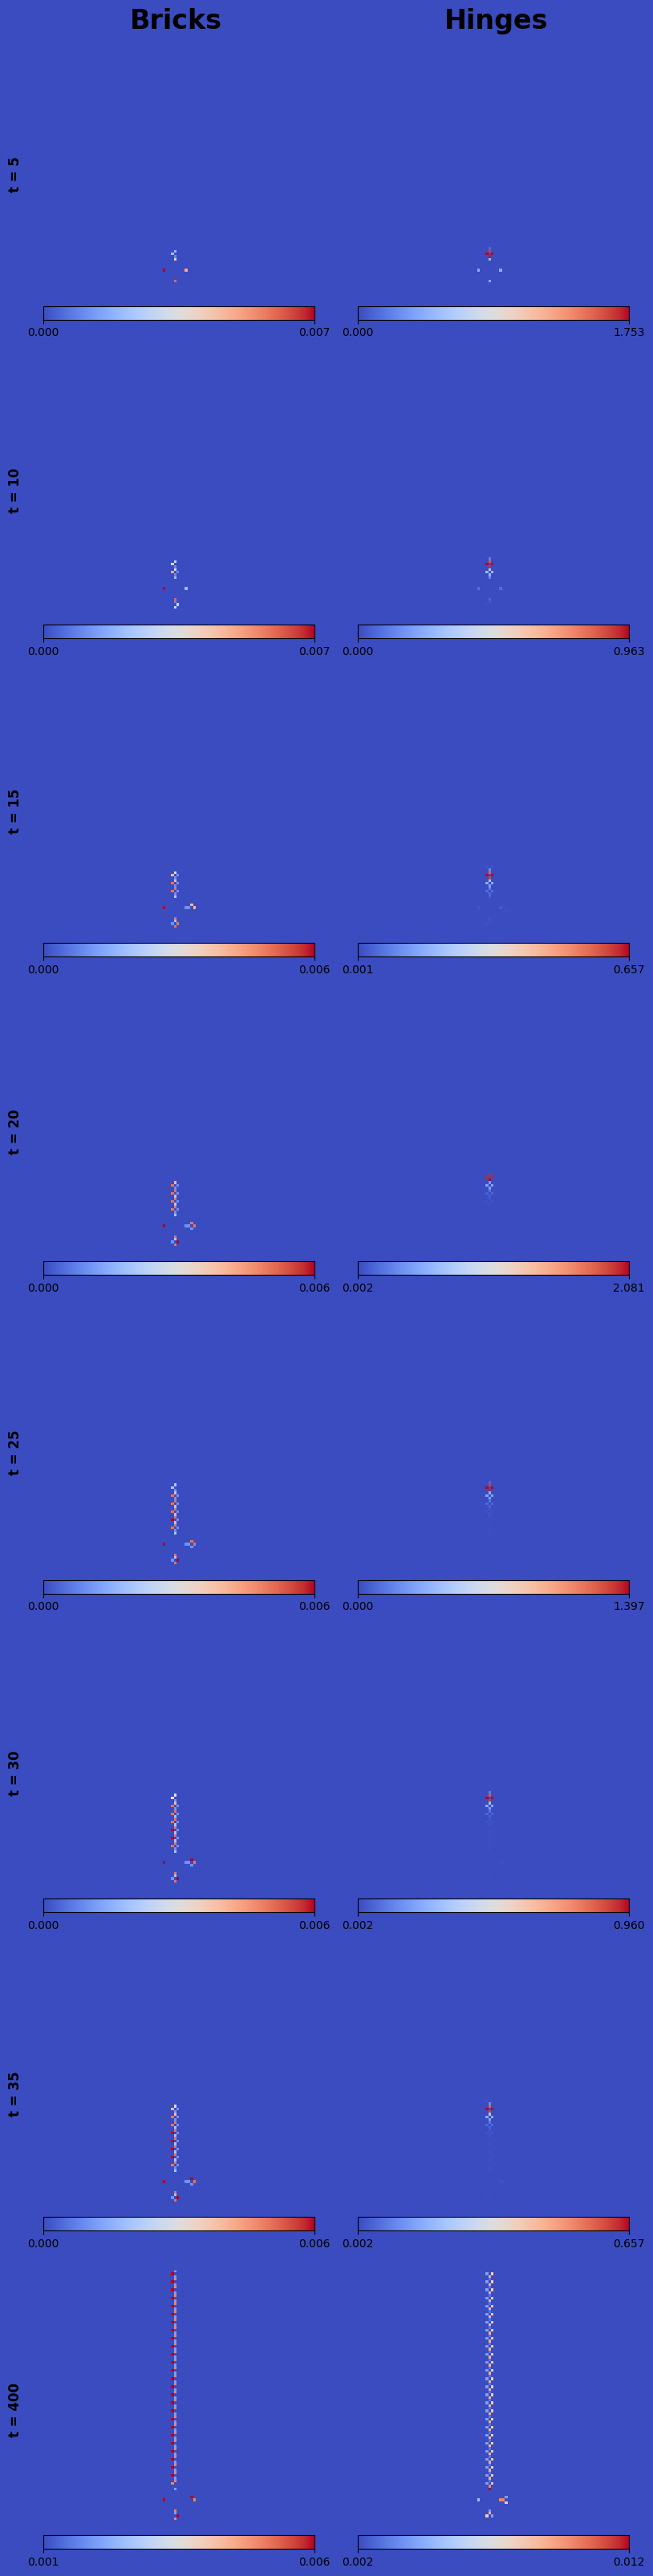

In [7]:
# ---- Plot
TFS = [3, 4]
gens = [5, 10, 15, 20, 25, 30, 35, 400]
# Initialize figure
fig, axes = plt.subplots(8, 2, figsize= (8, 32), facecolor = "white") # (8, 32)

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=8, hspace=None)
# Initialize color map and norm
cmap = plt.colormaps.get_cmap("coolwarm")

for igen, gen in enumerate(gens):
    # Get number of nodes
    node_est = []
    for tf in TFS: 
        new_idxs = np.argwhere([concentrations[tf][:, gen] != 0])
        if len(new_idxs) != 0: node_est.append(new_idxs)
        else: node_est.append(np.array([0] * len(TFS)))
    nnodes = np.max([idx.max() for idx in node_est])
    # Get min and max
    minval = [np.min(concentrations[tf][:(nnodes + 1), gen]).round(3) for tf in TFS]
    maxval = [np.max(concentrations[tf][:(nnodes + 1), gen]).round(3) for tf in TFS]
    # Correct for equal values
    for ival, val in enumerate(minval):
        if (minval[ival] == maxval[ival]) and (maxval[ival] != 0): minval[ival] = 0
        elif (minval[ival] == maxval[ival]) and (maxval[ival] == 0): maxval[ival] = 1

    # Loop over the TFs
    for itf, tf in enumerate(TFS):#range(1, 6):
        # Initialize grid
        expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))

        # Set the concentrations on an expanded grid for TF1
        middle_core = 0
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                # # Save core index?
                # if (i + xbounds[0], j + ybounds[0]) == (0, 0):
                #     core_index = [i * 3, j * 3]
                
                if (grid[i, j] == 1) and ((i + xbounds[0], j + ybounds[0]) not in [(1, 0), (0, 1),
                                                        (-1, 0), (0, -1), (1, 1), (-1, -1), (-1, 1), (1, -1)]):
                    # Get index of the coordinates
                    idx_coordinates = coordinates.index([i + xbounds[0], j + ybounds[0]])
                    idx = idx_coordinates - 8 # Subtract 8 to get the correct index for the concentrations
                    
                    # Check if core
                    if idx <= 0:
                        bool_core = True
                    else:
                        bool_core = False

                    # Tijdelijk --> core nog toevoegen
                    if not bool_core:
                        for c in range(4):
                            row = i * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][0]
                            col = j * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][1]
                            expanded_grid[row, col] = concentrations[tf][int(idx * 4 + c), gen].round(3)
                    else:
                        for c in range(4):
                            if c == 0: 
                                row = i * 3 + 2 + 3
                                col = j * 3 + 1 + 0
                            elif c == 3: # Somehow left and right are switched
                                row = i * 3 + 1 + 0
                                col = j * 3 + 2 + 3
                            elif c == 2:
                                row = i * 3 - 3
                                col = j * 3 + 1 + 0
                            elif c == 1:
                                row = i * 3 + 1 + 0
                                col = j * 3 - 3
                            #expanded_grid[row:int(row + 3), col:int(col + 3)] = concentrations[tf][int(idx * 4), gen]
                            expanded_grid[row,col] = concentrations[tf][c, gen].round(3)
                            #middle_core += 0.25 * concentrations[tf][c, gen]
                        #expanded_grid[i * 3 + 1, j * 3 + 1] = middle_core.round(2)
            
        #expanded_grid[core_index[0]:core_index[0] + 3, core_index[1]:core_index[1] + 3] = middle_core
        # # ---- Plot
        # if igen == 0:
        #     expanded_grid = expanded_grid[15:-15, 15:-15]
        # elif igen == 1:
        #     expanded_grid = expanded_grid[15:-15, 15:-15]
        # elif igen == 2:
        #     expanded_grid = expanded_grid[15:-15, 15:-15]
        
        # # Get min and max rows and columns with values
        # if np.sum(expanded_grid) == 0: pass
        # else:
        #     rows = np.where(np.sum(expanded_grid, axis = 1) != 0)[0]
        #     cols = np.where(np.sum(expanded_grid, axis = 0) != 0)[0]
        #     expanded_grid = expanded_grid[rows[0]:rows[-1] + 1, cols[0]:cols[-1] + 1]
        # Get axis
        im = axes[igen, itf].imshow(expanded_grid, cmap = cmap, vmin = minval[itf], vmax = maxval[itf])

        # ---- Colorbar
        cbar = fig.colorbar(im, ax = axes[igen, itf], orientation = "horizontal", pad = 0.05)
        # Set colorbar ticks
        cbar.set_ticks([minval[itf], maxval[itf]])
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        
        # Plot min and max as text
        # ax.text(0, 0.9, f"Min: {minval[itf]:.2f}", 
        #         fontsize = 8, color = "black", transform = ax.transAxes, ha = "center")
        # ax.text(0, 0.85, f"Max: {maxval[itf]:.2f}",
        #         fontsize = 8, color = "black", transform = ax.transAxes, ha = "center")
        axes[igen, itf].axis("off")
        axes[igen, itf].set_aspect("equal")
        # Remove tick indicators
        axes[igen, itf].set_xticks([])
        axes[igen, itf].set_yticks([])

    # # ---- Set last figure blank
    # ax[5].axis("off")
    # ax[5].set_aspect("equal")
    # ax[5].set_xticklabels([])
    # ax[5].set_yticklabels([])
    # # Remove tick indicators
    # ax[5].set_xticks([])
    # ax[5].set_yticks([])

# ---- Text
for itf, tf in enumerate(TFS):
    fig.text((itf + 0.5) / 2, 1, {3: "Bricks", 4: "Hinges"}[tf], 
                        fontsize = 24, color = "black", fontweight = "bold", ha = "center")
for igen, gen in enumerate(gens):
    fig.text(0, 1  - ((igen + 0.5) / len(gens)), f"t = {gen}", 
            fontsize = 12, rotation = 90, color = "black", fontweight = "bold",
            ha = "center")

# ---- Return
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.tight_layout()
plt.margins(0, 0)
# Background color
fig.patch.set_facecolor(cmap(0))
plt.show()


# GIF of Concentrations over Time

In [8]:
# Write gif of the concentrations --> normalized per timestep
import gif

# ---- Settings
TFS = [1, 2, 3, 4, 5]
figsize = 5
# Initialize color map
cmap = plt.colormaps.get_cmap("coolwarm")

@gif.frame
def animate(gen):
    # Initialize figure
    fig, axes = plt.subplots(1, len(TFS), figsize= (20, figsize), facecolor = "white") # snakes: (20, 20)

    # Get number of nodes
    node_est = []
    for tf in TFS: 
        new_idxs = np.argwhere([concentrations[tf][:, gen] != 0])
        if len(new_idxs) != 0: node_est.append(new_idxs)
        else: node_est.append(np.array([0] * len(TFS)))
    nnodes = np.max([idx.max() for idx in node_est])
    # Get min and max
    minval = [np.min(concentrations[tf][:(nnodes + 1), gen]).round(3) for tf in TFS]
    maxval = [np.max(concentrations[tf][:(nnodes + 1), gen]).round(3) for tf in TFS]
    # Correct for equal values
    for ival, val in enumerate(minval):
        if (minval[ival] == maxval[ival]) and (maxval[ival] != 0): minval[ival] = 0
        elif (minval[ival] == maxval[ival]) and (maxval[ival] == 0): maxval[ival] = 1

    # Loop over the TFs
    for itf, tf in enumerate(TFS):#range(1, 6):
        # Initialize grid
        expanded_grid = np.zeros((grid.shape[0] * 3, grid.shape[1] * 3))

        # Set the concentrations on an expanded grid for TF1
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if (grid[i, j] == 1) and ((i + xbounds[0], j + ybounds[0]) not in [(1, 0), (0, 1),
                                                        (-1, 0), (0, -1), (1, 1), (-1, -1), (-1, 1), (1, -1)]):
                    # Get index of the coordinates
                    idx_coordinates = coordinates.index([i + xbounds[0], j + ybounds[0]])
                    idx = idx_coordinates - 8 # Subtract 8 to get the correct index for the concentrations
                    
                    # Check if core
                    if idx <= 0:
                        bool_core = True
                    else:
                        bool_core = False

                    # Tijdelijk --> core nog toevoegen
                    if not bool_core:
                        for c in range(4):
                            row = i * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][0]
                            col = j * 3 + 1 + directions[tuple(coordinates[idx_coordinates])][c][1]
                            expanded_grid[row, col] = concentrations[tf][int(idx * 4 + c), gen].round(3)
                    else:
                        for c in range(4):
                            if c == 0: 
                                row = i * 3 + 2 + 3
                                col = j * 3 + 1 + 0
                            elif c == 3: # Somehow left and right are switched
                                row = i * 3 + 1 + 0
                                col = j * 3 + 2 + 3
                            elif c == 2:
                                row = i * 3 - 3
                                col = j * 3 + 1 + 0
                            elif c == 1:
                                row = i * 3 + 1 + 0
                                col = j * 3 - 3
                        
                            expanded_grid[row,col] = concentrations[tf][c, gen].round(3)
        # Add rows to top of expanded grid
        expanded_grid = np.vstack((np.zeros((10, expanded_grid.shape[1])), expanded_grid))

        # Get axis
        im = axes[itf].imshow(expanded_grid, cmap = cmap, vmin = minval[itf], vmax = maxval[itf])

        # ---- Colorbar
        cbar = fig.colorbar(im, ax = axes[itf], orientation = "horizontal", pad = 0.05)
        # Set colorbar ticks
        cbar.set_ticks([minval[itf], maxval[itf]])
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        cbar.ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        
        # Plot min and max as text
        # ax.text(0, 0.9, f"Min: {minval[itf]:.2f}", 
        #         fontsize = 8, color = "black", transform = ax.transAxes, ha = "center")
        # ax.text(0, 0.85, f"Max: {maxval[itf]:.2f}",
        #         fontsize = 8, color = "black", transform = ax.transAxes, ha = "center")
        axes[itf].axis("off")
        axes[itf].set_aspect("equal")
        # Remove tick indicators
        axes[itf].set_xticks([])
        axes[itf].set_yticks([])
    
    # ---- Text
    fontsize = 24 if figsize == 20 else 12
    if figsize == 20: 
        loc = 0.1 
    else: loc = 0.05
    fig.text(0.2 / len(TFS), loc, f"Time: {gen}", 
                            fontsize = fontsize, color = "black", fontweight = "bold", ha = "center")
    for itf, tf in enumerate(TFS):
        fig.text((itf + 0.5) / len(TFS), 0.97, {1: "rTF1", 2: "rTF2", 
                                      3: "Bricks", 4: "Hinges", 5: "Rotation"}[tf], 
                            fontsize = fontsize, color = "black", fontweight = "bold", ha = "center")
    

    # ---- Return
    plt.subplots_adjust(hspace = 0, wspace = 0)
    plt.tight_layout()
    # Background color
    fig.patch.set_facecolor(cmap(0))

frames = []
for i in range(0, concentrations[1].shape[1]):
    # Print progress
    print(f"Frame {i} of {concentrations[1].shape[1]}", end = "\r")
    # Append
    frames.append(animate(i))
    
# ----- Export gif
gif.save(frames, f"Tfs.gif", duration = 300)


# Analyze Genotype

In [9]:
import os
os.environ["ALGORITHM"] = "GRN_system"
os.environ["MODE"] = "evolution"
os.environ["DATABASE_FILE"] = ".sqlite"

# Import other modules
import pandas as pd
from experiment import Experiment
from generation import Generation
from individual import Individual
from population import Population
from sqlalchemy import select
from sqlalchemy.orm import Session

from revolve2.experimentation.database import OpenMethod, open_database_sqlite
from revolve2.experimentation.logging import setup_logging

# Import parameters
import config
os.environ['MAXPARTS'] = str(config.MAX_PARTS)

# Import the genotype
if os.environ["ALGORITHM"] == "CPPN":
    from genotype import Genotype
elif os.environ["ALGORITHM"] in ["GRN", "GRN_system", "GRN_system_adv"]:
    from genotype_grn import Genotype
else:
    raise ValueError("ALGORITHM must be either GRN or CPPN")

C:\Users\niels\AppData\Local\Temp\ipykernel_19336\393696407.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [10]:
def select_data(dbengine, column: str, body_id = True) -> pd.DataFrame:
    """Goal:
        Select the data of the column
    -------------------------------------------------------------
    Input:
        dbengine: ?
        column: The column that needs to be selected
        body_id: Whether the body_id should be included
    --------------------------------------------------------------
    Output:
        df: pd.Dataframe"""
    if body_id:
        df = pd.read_sql(
            select(Genotype, Experiment.id.label("experiment_id"), Generation.generation_index, 
                getattr(Individual, column), Individual.id.label("individual_id"),
                Individual.body_id)
            .join_from(Experiment, Generation, Experiment.id == Generation.experiment_id)
            .join_from(Generation, Population, Generation.population_id == Population.id)
            .join_from(Population, Individual, Population.id == Individual.population_id)
            .join_from(Individual, Genotype, Individual.genotype_id == Genotype.id),
            dbengine,
        )
    else:
        df = pd.read_sql(
            select(Genotype, Experiment.id.label("experiment_id"), Generation.generation_index, 
                getattr(Individual, column), Individual.id.label("individual_id"))
            .join_from(Experiment, Generation, Experiment.id == Generation.experiment_id)
            .join_from(Generation, Population, Generation.population_id == Population.id)
            .join_from(Population, Individual, Population.id == Individual.population_id)
            .join_from(Individual, Genotype, Individual.genotype_id == Genotype.id),
            dbengine,
        )

    return df

# Get Genotypes of Best Runs

In [11]:
column = "fitness"
folder_paths = {"GRN": "C:\\Users\\niels\\Downloads\\GRN_runs\\",
                "mrGRN": "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution\\"}

In [12]:
genotypes = {"GRN": {}, "mrGRN": {}}

for algo, folder_path in folder_paths.items():
    print("Processing: ", algo)
    for file in os.listdir(folder_path):
        print("File:", file)
        if file.endswith(".sqlite"):
            # Open database
            dbengine = open_database_sqlite(folder_path + "\\" + file, open_method=OpenMethod.OPEN_IF_EXISTS)

            # Get pandas data
            df_sub = select_data(dbengine, column, body_id = False)
            # Get experiments
            experiments = df_sub["experiment_id"].unique()
            # Get sample with max fitness per experiment
            for exp in experiments:
                df_sub_exp = df_sub[df_sub["experiment_id"] == exp]
                max_fitness = df_sub_exp["fitness"].max()
                sample = df_sub_exp[df_sub_exp["fitness"] == max_fitness].iloc[0]
                
                # Store
                serialized_body = sample["serialized_body"].split(",")
                genotypes[algo][sample["fitness"]] = np.array(serialized_body).astype(np.float64)
        

Processing:  GRN
File: CSV
File: database_GRN_300_1.sqlite
File: database_GRN_300_10.sqlite
File: database_GRN_300_2.sqlite
File: database_GRN_300_3.sqlite
File: database_GRN_300_4.sqlite
File: database_GRN_300_5.sqlite
File: database_GRN_300_6.sqlite
File: database_GRN_300_7.sqlite
File: database_GRN_300_8.sqlite
File: database_GRN_300_9.sqlite


In [ ]:
# Get first 7 values of mrGRNs
values = []
for fitness, gen in genotypes["mrGRN"].items():
    values.append(gen[0:7])

new_genotypes = {}
for fitness, gen in genotypes["GRN"].items():
    new_genotypes[str(fitness) + "_" + str(0)] = gen.tolist()
    i = 1
    for vals in values:
        new_genotypes[str(fitness) + "_" + str(i)] = np.concatenate((vals, gen[1:])).tolist()
        new_genotypes[str(fitness) + "_" + str(i)][0] = gen[0]
        i += 1

# To json
import json
with open("genotypes.json", "w") as f:
    json.dump(new_genotypes, f)

In [ ]:
mappings = {0: "concentration threshold", 1: "concentration decay", 2: "intra diffusion rate",
 3: "inter diffusion rate", 4: "capacity core", 5: "capacity hinge", 6: "capacity brick",}

In [ ]:
df = pd.DataFrame([])
n_exp = 0
for file in os.listdir(folder_path):
    print("File:", file)
    if file.endswith(".sqlite"):
        # Open database
        dbengine = open_database_sqlite(folder_path + "\\" + file, open_method=OpenMethod.OPEN_IF_EXISTS)

        # Get pandas data
        df_sub = select_data(dbengine, column)
        df_sub["experiment_id"] = ((df_sub["experiment_id"] - df_sub["experiment_id"].min()) + n_exp).astype(int).values
        # Print ids and max fitness
        ids = df_sub["experiment_id"].unique()
        for id in ids:
            print(f"Experiment {id}: {df_sub.loc[df_sub['experiment_id'] == id, column].max()}")
        
        # Convert genotype columns
        #df_sub["length genotype"] = df_sub["serialized_body"].apply(lambda x: x.count(",")) + 1
        #genotype = df_sub["serialized_body"].apply(lambda x: [float(ix) for ix in x.split(',')[0:7]])

        # for imap, keymap in mappings.items():
        #     df_sub[keymap] = genotype.apply(lambda x: x[imap])

        
        # Drop serialized_body, serialized_brain
        df_sub = df_sub.drop(columns = ["serialized_body", "serialized_brain"])

        # Update n_exp
        n_exp = df_sub["experiment_id"].max() + 1

        # Concat data
        df = pd.concat([df, df_sub], axis = 0)

# Save data
df.to_csv(f"genotype_and_fitness_{os.environ['ALGORITHM']}.csv", index = False)

# # Select even generations
# if os.environ["MODE"] == "evolution":
#     first_generation = df.loc[df["generation_index"] == 0, :]
#     df = df.loc[(df.loc[:, "generation_index"] % 2) == 0, :]
#     df = pd.concat([first_generation, df])
#     df["generation_index"] = (df.loc[:, "generation_index"] / 2).astype(int).values
# else:
#     raise ValueError("MODE must be evolution")
        

File: CSV
File: database_GRN_300_1.sqlite
Experiment 0: 9.805413927057321
File: database_GRN_300_10.sqlite
Experiment 1: 6.0025720183715725
Experiment 2: 3.817138667715245
File: database_GRN_300_11.sqlite
Experiment 3: 6.414818702949956
File: database_GRN_300_12.sqlite
Experiment 4: 9.07365448242234
File: database_GRN_300_13.sqlite
Experiment 5: 6.420431262871015
File: database_GRN_300_2.sqlite
Experiment 6: 10.587086858382674
Experiment 7: 6.197483584028902
File: database_GRN_300_3.sqlite
Experiment 8: 7.212634011607761
Experiment 9: 10.727024154887758
File: database_GRN_300_4.sqlite
Experiment 10: 3.7395864359043505
File: database_GRN_300_5.sqlite
Experiment 11: 4.958725895528281
Experiment 12: 5.549891689130819
File: database_GRN_300_6.sqlite
Experiment 13: 4.238522933815388
File: database_GRN_300_7.sqlite
Experiment 14: 5.842911116031192
Experiment 15: 10.093784613435556
File: database_GRN_300_8.sqlite
Experiment 16: 7.139723657574412
Experiment 17: 13.106315281728701
File: databas

In [ ]:
if os.environ["ALGORITHM"] == "GRN_system":
    if os.environ["MODE"] == "evolution":
        path2morph = "C:\\Users\\niels\\Downloads\\GRN_system_runs\\Evolution\\CSV\\Morphology.csv"
        df_morph = pd.read_csv(path2morph)
    else:
        pass
elif os.environ["ALGORITHM"] == "CPPN":
    if os.environ["MODE"] == "evolution":
        path2morph = "C:\\Users\\niels\\Downloads\\CPPN\\Evolution\\Morphology.csv"
        df_morph = pd.read_csv(path2morph)
elif os.environ["ALGORITHM"] == "GRN":
    if os.environ["MODE"] == "evolution":
        path2morph = "C:\\Users\\niels\\Downloads\\GRN_runs\\CSV\\Morphology.csv"
        df_morph = pd.read_csv(path2morph)
    else:
        pass

df = pd.read_csv(f"genotype_and_fitness_{os.environ['ALGORITHM']}.csv")

In [ ]:
# Sort values
df = df.sort_values(by = ["experiment_id", "generation_index", "individual_id"])
df_morph = df_morph.sort_values(by = ["experiment_id", "generation_index", "individual_index"])

# Map4match
map4match = {}
for exp in df["experiment_id"].unique():
    if os.environ["ALGORITHM"] != "GRN":
        data_exp_id = df.loc[df["experiment_id"] == exp, "body_id"]
    else: # Because I had no body_id in the GRN runs, because I developed it later on
        loczeros = (df.loc[df["experiment_id"] == exp, "fitness"] == 7.950135414923488e-19)

    map4match[exp] = None
    for exp_morph in df_morph["experiment_id"].unique():
        data_exp_id_morph = df_morph.loc[df_morph["experiment_id"] == exp_morph, "id_string"]
        if os.environ["ALGORITHM"] != "GRN":
            if (data_exp_id_morph[0:10].values == data_exp_id[0:10].values).all():
                assert map4match[exp] is None
                map4match[exp] = exp_morph
            else: pass
        else:
            loczeros2 = data_exp_id_morph == "1|"
            if pd.Series(loczeros.values).equals(pd.Series(loczeros2.values)):
                assert map4match[exp] is None
                map4match[exp] = exp_morph
            else: pass        

In [ ]:
print(map4match)
assert len(np.unique(map4match.values())[0]) == len(map4match.values())

{0: 1, 1: 19, 2: 20, 3: 21, 4: 23, 5: 25, 6: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 9, 12: 10, 13: 11, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18}


In [ ]:
# Add morphological data
df.replace({"experiment_id": map4match}, inplace = True)
df.sort_values(by = ["experiment_id", "generation_index", "individual_id"], inplace = True)
df.reset_index(drop = True, inplace = True)
df_morph.sort_values(by = ["experiment_id", "generation_index", "individual_index"], inplace = True)
df_morph.reset_index(drop = True, inplace = True)

# Check duplicate columns
for col in df.columns:
    if col in df_morph.columns:
        assert (df[col] == df_morph[col]).all()
        df = df.drop(columns = col)
# # Concatenate the data
df = pd.concat([df, df_morph], axis = 1)

In [ ]:
print(df.columns)

Index(['id', 'fitness', 'individual_id', 'body_id', 'bricks', 'hinges',
       'modules', 'size', 'proportion2d', 'proportionNiels',
       'single_neighbour_brick_ratio', 'single_neighbour_ratio',
       'double_neighbour_brick_and_active_hinge_ratio', 'maxrel_llimbs',
       'meanrel_llimbs', 'stdrel_llimbs', 'nlimbs', 'joints',
       'joint_brick_ratio', 'symmetry_incl1', 'symmetry_incl2',
       'symmetry_incl3', 'symmetry_incl4', 'symmetry_excl1', 'symmetry_excl2',
       'symmetry_excl3', 'symmetry_excl4', 'coverage', 'branching',
       'surface_area', 'id_string', 'experiment_id', 'generation_index',
       'individual_index'],
      dtype='object')


In [ ]:
assert df["body_id"].equals(df["id_string"])
assert df["individual_id"].equals(df["individual_index"])
df.drop(columns = ["body_id", "individual_id"], inplace = True)
df.to_csv(f"morphology_and_fitness_evo_{os.environ['ALGORITHM']}.csv", index = False)

KeyError: "['length genotype', 'concentration threshold', 'concentration decay', 'intra diffusion rate', 'inter diffusion rate', 'capacity core', 'capacity hinge', 'capacity brick'] not in index"

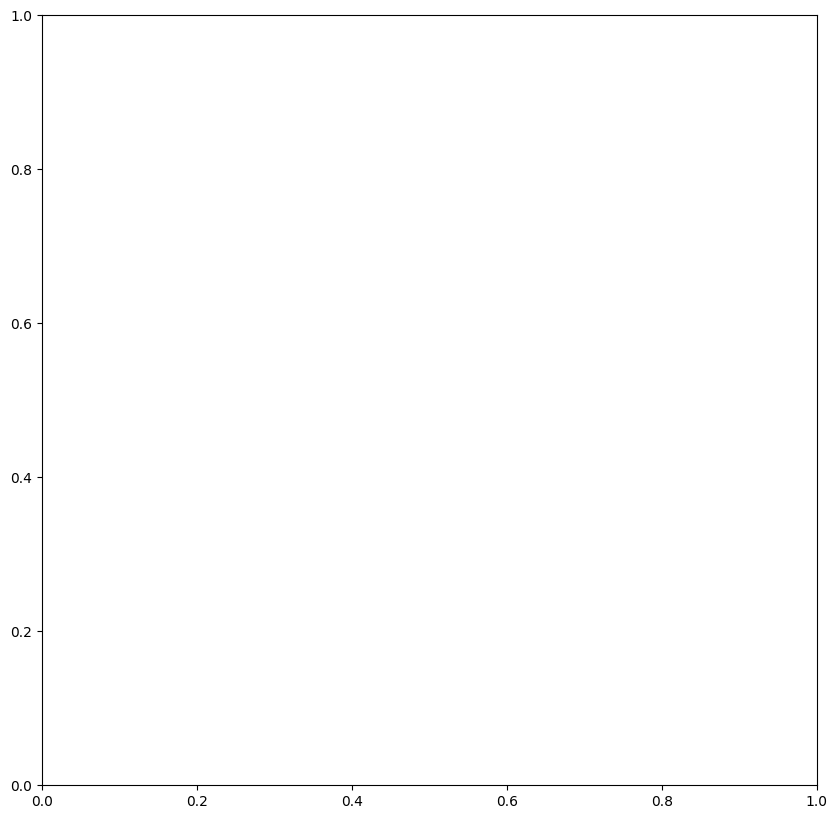

In [ ]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Data
columns = ["fitness", "length genotype"] + list(mappings.values())
data = df.loc[df["generation_index"] == 600, columns]
# Normalize data
data = (data - data.mean()) / data.std()

# Plot
plt.boxplot(data, widths = 0.6, patch_artist = True, boxprops=dict(facecolor="red"))
ax.set_xlabel("Generation", fontsize = 15, fontweight = "bold")
ax.set_ylabel("Normalized values", fontsize = 15, fontweight = "bold")
ax.set_title("Boxplot of the fitness and genotype parameters", fontsize = 20, fontweight = "bold")
ax.set_xticklabels(columns, rotation = 45, ha = "right")
# Remove axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# Set axes thickness
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
# Remove tick indicators on axes
ax.tick_params(which = "both", width = 0)
ax.legend()
plt.show()

In [ ]:
data = df.loc[:, ["generation_index", "experiment_id"] + columns].groupby(["experiment_id", "generation_index"]).median()

for column in columns:
    plt.plot(data[column].unstack().T)
    plt.title(column)
    plt.show()

In [ ]:
# Get offspring
df_offspring = df.loc[df["generation_index"] % 2 != 0, :]

# Get percentage of ids that equals "1|" per generation
percentage = df_offspring.loc[df_offspring["id_string"] == "1|", :].groupby("generation_index").size() / df_offspring.groupby("generation_index").size()

plt.plot(percentage)


In [ ]:
import seaborn as sns
# Data
columns = ["fitness", "length genotype", "body_id"] + list(mappings.values())
data = df.loc[df["generation_index"] == 0, columns]
body_ids = data["body_id"].values
data = data.drop(columns = "body_id")
columns.remove("body_id")
# Normalize data
data = (data - data.mean()) / data.std()

# Select
data = data.loc[body_ids == "1|", columns]

# # Plot
# fig, ax = plt.subplots(1, 1, figsize = (10, 10))
# plt.boxplot(data, widths = 0.6, patch_artist = True, boxprops=dict(facecolor="red"))
# ax.set_xlabel("Generation", fontsize = 15, fontweight = "bold")
# ax.set_ylabel("Normalized values", fontsize = 15, fontweight = "bold")
# ax.set_title("Boxplot of the fitness and genotype parameters", fontsize = 20, fontweight = "bold")
# ax.set_xticklabels(columns, rotation = 45, ha = "right")
# # Remove axes
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# # Set axes thickness
# ax.spines["left"].set_linewidth(2)
# ax.spines["bottom"].set_linewidth(2)
# # Remove tick indicators on axes
# ax.tick_params(which = "both", width = 0)
# ax.legend()
# plt.show()
# Violin plot
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.violinplot(data = data, ax = ax)
ax.set_xlabel("Generation", fontsize = 15, fontweight = "bold")
ax.set_ylabel("Normalized values", fontsize = 15, fontweight = "bold")
ax.set_title("Violin plot of the fitness and genotype parameters", fontsize = 20, fontweight = "bold")
ax.set_xticklabels(columns, rotation = 45, ha = "right")
# Remove axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# Set axes thickness
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
# Remove tick indicators on axes
ax.tick_params(which = "both", width = 0)
ax.legend()
plt.show()

In [ ]:
# Data
columns = ["fitness", "length genotype", "body_id"] + list(mappings.values())
data = df.loc[df["generation_index"] == 0, columns]
body_ids = data["body_id"].values
data = data.drop(columns = "body_id")
columns.remove("body_id")
# Normalize data
data = (data - data.mean()) / data.std()

# Select
data = data.loc[body_ids == "1|", columns]

for icolumn, column in enumerate(columns):
    if column in ["fitness", "length genotype"]:
        continue
    for column2 in columns[icolumn + 1:]:
        plt.scatter(data[column], data[column2])
        plt.title(f"{column} vs {column2}")
        plt.show()